# LELA 60331  Computational Linguistics 1
### Week 12¶

Today we are going to use Pytorch to perform classification with sequence models.

The first dataset we are going to work with consists of just over 10,000 surnames, labelled with 18 different nationalities. The first tasks will be to learn a classifier that can accurately assign a nationality to previously unseen surnames. To do this we will use an LSTM.

In [1]:
! wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/surnames_data.csv

--2025-12-14 08:50:55--  https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/surnames_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179708 (175K) [text/plain]
Saving to: ‘surnames_data.csv’

surnames_data.csv   100%[===================>] 175.50K  --.-KB/s    in 0.003s  

2025-12-14 08:50:56 (63.8 MB/s) - ‘surnames_data.csv’ saved [179708/179708]



We read the data into a Pandas dataframe:

In [2]:
import pandas as pd
import torch
surnames_df=pd.read_csv("surnames_data.csv")
surnames_df

,nationality,surname
0,Arabic,Totah
1,Arabic,Abboud
2,Arabic,Fakhoury
3,Arabic,Srour
4,Arabic,Sayegh
...,...,...
10975,Vietnamese,Dinh
10976,Vietnamese,Phung
10977,Vietnamese,Quang
10978,Vietnamese,Vu


We then use hierachical indexing in Pandas to represent the data as sequences of separate characters

In [3]:
import pandas as pd
import torch
surnames_df=pd.read_csv("surnames_data.csv")

chars=[]
index_1=[]
index_2=[]
for i,row in surnames_df.iterrows():
    chars.extend(list(row.surname))
    index_1.extend([i]*len(row.surname))
    index_2.extend(range(len(row.surname)))

surnames_chars = pd.DataFrame(chars,index=[index_1,index_2])
surnames_chars.columns = ["chars"]
surnames_chars

chars
0     0     T
      1     o
      2     t
      3     a
      4     h
...       ...
10977 4     g
10978 0     V
      1     u
10979 0     H
      1     a

[73143 rows x 1 columns]

We can then use the Pandas function get_dummies to produce one-hot codings of the characters

In [4]:
surnames_oh=pd.get_dummies(surnames_chars.chars,dtype=int)
surnames_oh

'  -  /  1  :  A  B  C  D  E  ...  ö  ù  ú  ü  ą  ł  ń  Ś  Ż  ż
0     0  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      1  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      2  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      3  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      4  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
...     .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
10977 4  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
10978 0  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      1  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
10979 0  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
      1  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0

[73143 rows x 84 columns]

And the nationalities

In [5]:
nationalities_oh=pd.get_dummies(surnames_df.nationality,dtype=int)
nationalities_oh

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


We will then turn these into tensors for input to PyTorch and in particular to an LSTM layer. We want a tensor with the shape [Number_of_names, Number_of_characters_in name, Size_of_alphabet].

However the LSTM layer requires that all sequence be of the same length and so we pad our tensors by adding N tensors of zeros of the length of the one hot codings to the beginning of each name. So that the tensor actually has the form [Number_of_names, Number_of_characters_in_the_longest_name, Size_of_alphabet]

We do this using the function ZeroPad1d which takes as an argument a tuple with the following entries: padding_left, padding_right, padding_above, padding below.





In [6]:
from torch import nn
t=torch.ones([5,5,5])
print(t[0,:,:])
m = nn.ZeroPad1d((0,0,2,0))
print(m(t))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
      

In [7]:
from torch import nn
# Find the length of the longest name in the data:
max_length=max([t[1] for t in surnames_oh.index])
# Make an array for the name tensors
X = [0] * (max(surnames_oh.index)[0]+1)
# Make an array for the label tensors
y = [0] * (max(nationalities_oh.index)+1)
# Iterate over index of the surnames one-hot data frame. The indices are tuples.
for ind in surnames_oh.index:
    # Make a tensor from subset of the dataframe for this name/index
    s=torch.from_numpy(surnames_oh.loc[ind[0]].values).to(dtype=torch.float)
    # Pad the tensor
    m = nn.ZeroPad1d((0,0,max_length-len(s),0))
    # Add tensors to arrays
    X[ind[0]] = m(s).cuda()
    y[ind[0]] = torch.from_numpy(nationalities_oh.loc[ind[0]].values).to(dtype=torch.float).cuda()
# Combine contents of arrays into a single tensor
X=torch.stack(X)
y=torch.stack(y)

In [8]:
X.shape

torch.Size([10980, 16, 84])

In [9]:
y.shape

torch.Size([10980, 18])

### LSTM layers in PyTorch

LSTM layers can be specified as follows. We need to specify the size of the input (e.g. the length our one-hot vectors), the size of the hidden layer to use, the number of layers to include. And because of the way that our data is configured we use the batch_first flag.


In [10]:
input=torch.randn((1,10,10))
lstm = nn.LSTM(input_size=10, hidden_size=5, num_layers=1, batch_first=True)
output, (hidden, cell)=lstm(input)
print(output)

tensor([[[ 0.2113, -0.2084,  0.0303, -0.2014,  0.0796],
         [ 0.2651, -0.1338,  0.0772, -0.0639,  0.0994],
         [ 0.3537,  0.1653,  0.3485,  0.1090,  0.0187],
         [ 0.2936,  0.2719,  0.1816, -0.1024, -0.0235],
         [ 0.1260,  0.1069, -0.1298, -0.2660, -0.1726],
         [ 0.3975,  0.1663, -0.0673, -0.1162, -0.0292],
         [ 0.1327, -0.0218,  0.0643, -0.2306, -0.1337],
         [ 0.2819, -0.3463,  0.1447, -0.3915, -0.2214],
         [ 0.1640, -0.0324,  0.6655, -0.1725, -0.0912],
         [ 0.2054, -0.0436,  0.3423, -0.1976, -0.1798]]],
       grad_fn=<TransposeBackward0>)


The output is the final hidden layers from each step of the sequence. The second element output is a tuple containing the hidden and cell states from all layers and timepoints. Here we are interested in the hidden layer values as it is the hidden layer from final step for each sequence that we will pass on to a linear layer to perform classification. We could take this from either the output or the hidden objects. In our code we take this from the output.

In [11]:
hidden.shape

torch.Size([1, 1, 5])

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_classes = 18

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=84, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, n_classes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_classes = 18

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=84, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, n_classes)
    def forward(self, x):
        x, _ = self.rnn(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        return x

Now we have the model we can split the data then train and then test. We will use CrossEntropyLoss because our output is an 18-class softmax. We will use batch training.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Text(0, 0.5, 'loss')

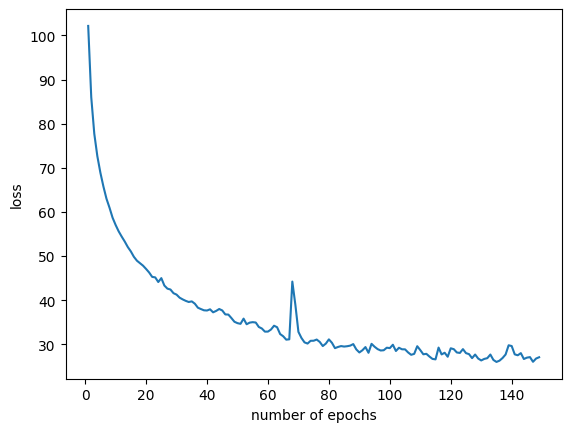

In [16]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs = 150
batch_size = 128
model = SeqModel()
model.to("cuda")
ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fn = nn.CrossEntropyLoss()

for i in range(n_epochs):
    cumul_loss = 0.0
    batches = gen_batches(X_train.shape[0],batch_size)
    cumul_loss=0.0
    for k in batches:
          inputs=X_train[k]
          outputs=y_train[k]
          y_pred = model(inputs)
          loss = loss_fn(y_pred, outputs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cumul_loss += loss.item()
    ce_loss.append(cumul_loss)

plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")



Our precision and recall are as follows:

In [19]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_test_pred=[np.argmax(x.cpu().detach().numpy()) for x in model(X_test)]
y_test_int=[np.argmax(x.cpu().detach().numpy()) for x in y_test]
precision_recall_fscore_support(y_test_int, y_test_pred, average='macro')


(0.40647000438141834, 0.4122238752522131, 0.4058715019176579, None)

We can try the model out on individual names as follows:

In [22]:
name="bannard"
torch.manual_seed(42)
charset=list(surnames_oh.columns.values)
nationalities=list(nationalities_oh.columns.values)
oh = torch.zeros(16,len(charset))
for i,c in enumerate(name):
    oh[16-len(name)+i,charset.index(c)] = 1.0
oh=oh.to("cuda")
print(oh.shape)
pred=model(torch.unsqueeze(oh,0))
nationalities[np.argmax(pred.cpu().detach().numpy())]

torch.Size([16, 84])


'Dutch'

We can examine the model and its weights as follows:

In [77]:
model

SeqModel(
  (rnn): RNN(84, 42, batch_first=True)
  (linear): Linear(in_features=42, out_features=18, bias=True)
)

In [79]:
model.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[ 2.5568,  1.3396, -0.0361,  ...,  0.2616,  0.4358,  1.1397],
                      [ 1.7845, -0.7189,  0.0883,  ...,  0.8615, -0.0217, -0.9582],
                      [ 1.6348, -0.7047, -0.0781,  ..., -0.9293, -0.1256,  0.8417],
                      ...,
                      [ 2.8172, -2.2113, -0.0579,  ...,  2.2873, -2.1515, -0.9772],
                      [-3.5766, -1.3373,  0.0791,  ...,  0.0775, -0.1022, -0.3931],
                      [ 2.2141,  0.1675,  0.1135,  ..., -0.2905,  1.5725,  0.8104]])),
             ('rnn.weight_hh_l0',
              tensor([[ 1.9156e-01, -1.7648e-01, -4.7440e-01,  ..., -1.5907e-01,
                       -4.0301e-01, -3.6221e-02],
                      [-2.4668e-01,  5.8399e-02,  3.7295e-01,  ..., -4.1347e-01,
                       -2.2193e-01, -5.8319e-01],
                      [-1.5467e-01, -2.1984e-02, -5.9733e-01,  ..., -2.1648e-01,
                       -1.1440e-01,  9.8497e-02],
     

We can try to improve performance by using a gated RNN, specifically an LSTM (see week 12 lecture)

In [24]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_classes = 18

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=84, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, n_classes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        return x

Text(0, 0.5, 'loss')

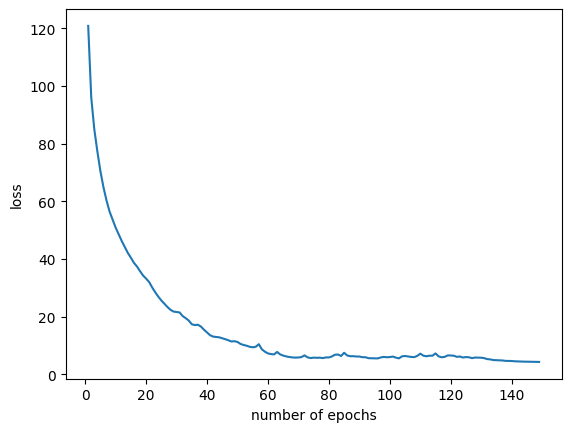

In [25]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs = 150
batch_size = 128
model = SeqModel()
model.to("cuda")
ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fn = nn.CrossEntropyLoss()


for i in range(n_epochs):
    cumul_loss = 0.0
    batches = gen_batches(X_train.shape[0],batch_size)
    cumul_loss=0.0
    for k in batches:
          inputs=X_train[k]
          outputs=y_train[k]
          y_pred = model(inputs)
          loss = loss_fn(y_pred, outputs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cumul_loss += loss.item()
    ce_loss.append(cumul_loss)

plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")





In [26]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_test_pred=[np.argmax(x.cpu().detach().numpy()) for x in model(X_test)]
y_test_int=[np.argmax(x.cpu().detach().numpy()) for x in y_test]
precision_recall_fscore_support(y_test_int, y_test_pred, average='macro')

(0.4388080363942072, 0.43692793629252774, 0.43427914988489635, None)

In [27]:
name="bannard"
torch.manual_seed(42)
charset=list(surnames_oh.columns.values)
nationalities=list(nationalities_oh.columns.values)
oh = torch.zeros(16,len(charset))
for i,c in enumerate(name):
    oh[16-len(name)+i,charset.index(c)] = 1.0
oh=oh.to("cuda")
print(oh.shape)
pred=model(torch.unsqueeze(oh,0))
nationalities[np.argmax(pred.cpu().detach().numpy())]

torch.Size([16, 84])


'German'

## Review classification with RNN


Next we will apply the same process to the Yelp review sentiment data that we have been working with all semester.

In order to speed things up I have prepared the Tensors that you need from the raw data. I have also only used a random sample of 1000 reviews to make training time manageable in class.

In [30]:
!gdown 19cYQ_B3diu6RqlpYT5n9qHvS08_cScp7
!gdown 1DHj5zFiWX3hF3o8RxMx2Hn4sOW-VsHTs

!gunzip reviews_for_rnn.pt.gz

Downloading...
From (original): https://drive.google.com/uc?id=19cYQ_B3diu6RqlpYT5n9qHvS08_cScp7
From (redirected): https://drive.google.com/uc?id=19cYQ_B3diu6RqlpYT5n9qHvS08_cScp7&confirm=t&uuid=f13012d5-8dac-46a2-a645-94a8788b2880
To: /content/reviews_for_rnn.pt.gz
100% 58.0M/58.0M [00:02<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DHj5zFiWX3hF3o8RxMx2Hn4sOW-VsHTs
To: /content/review_labels_for_rnn.pt
100% 9.68k/9.68k [00:00<00:00, 31.8MB/s]


In [31]:
import torch
reviews_emb=torch.load("reviews_for_rnn.pt")
labels=torch.load("review_labels_for_rnn.pt")

The tokens in the reviews are represented using 300 element static embedding vectors. The longest review is 887 tokens long so we pad all the sentence vectors to this length. There are 1000 reviews. So the input data is a 1000x887x300 3D tensor.

In [83]:
reviews_emb.shape

torch.Size([1000, 887, 300])

We split this into an 800 review training set and a 200 review test set as follows

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews_emb, labels, test_size=0.2, random_state=30)
X_train = X_train.to("cuda")
X_test = X_test.to("cuda")
y_train = y_train.to("cuda")
y_test = y_test.to("cuda")


Problem 1: Build an LSTM-based classifier for this review data. Note: this is a binary classifier so you will need to change the loss function and pass the output of your model x through torch.sigmoid()

In [39]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=300, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

Text(0, 0.5, 'loss')

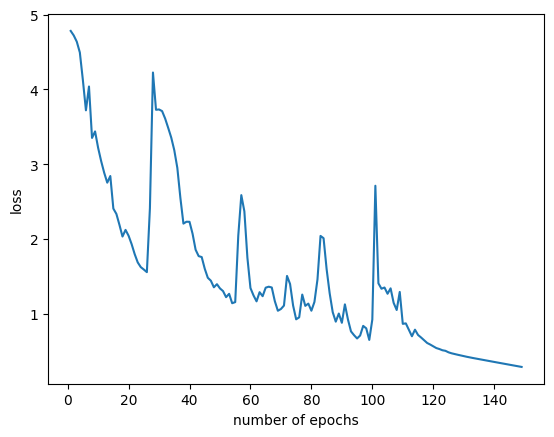

In [41]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs = 150
batch_size = 128
model = SeqModel()
model.to("cuda")
ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCELoss()

for i in range(n_epochs):
    cumul_loss = 0.0
    batches = gen_batches(X_train.shape[0],batch_size)
    cumul_loss=0.0
    for k in batches:
          inputs=X_train[k]
          outputs=y_train[k]
          y_pred = model(inputs)
          loss = loss_fn(torch.squeeze(y_pred), outputs.float())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cumul_loss += loss.item()
    ce_loss.append(cumul_loss)

plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

Once you have build it you can evaluate it as follows

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
labels_pred=(model(reviews_test) > 0.5).int().flatten().tolist()
precision_recall_fscore_support(labels, labels_pred)

### Intent classification with RNNs

Now we are going to work with some sentences - utterances input to a dialogue system assigned with the speaker intent.

'PlayMusic', e.g. "play easy listening" \
'AddToPlaylist' e.g. "please add this song to road trip" \
'RateBook' e.g. "give this novel 5 stars" \
'SearchScreeningEvent' e.g. "give me a list of local movie times" \
'BookRestaurant' e.g. "i'd like a table for four at 7pm at Asti" \
'GetWeather' e.g. "what's it like outside" \
'SearchCreativeWork' "show me the new James Bond trailer"



Problem 1: Build and train an RNN-based classifier using a training subset of the data that can correctly classify a test subset of the data.

I have prebuilt the tensors containing word embeddings for you:

In [ ]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/utts_emb.pt.gz
!gunzip utts_emb.pt.gz
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/intents_emb.pt
X_utts=torch.load("utts_emb.pt")
y_intents=torch.load("intents_emb.pt")

In [ ]:
X_utts.shape

In [ ]:
y_intents.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_utts, y_intents, test_size=0.2, random_state=30)
X_train=X_train.to("cuda")
X_test=X_test.to("cuda")
y_train=y_train.to("cuda")
y_test=y_test.to("cuda")


Once the model is trained you can calculate its accuracy as follows:


In [ ]:
import numpy as np
y_test_pred=[np.argmax(x.cpu().detach().numpy()) for x in model(X_test)]
np.mean([int(x == np.argmax(y_test.cpu().detach().numpy()[i])) for i,x in enumerate(y_test_pred)])

Problem 3: Starting from the Pandas data_frame intent_classification (imported as below), compile the data into the format needed by your model. Note that the utterances are of different lengths so you will need to do some padding. The data frame is hierachically indexed for utterance and word, so that the format is almost identical to the name data. Once you have compiled the data use it to train your model above.

In [ ]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/intent_classification.pickle

In [ ]:
intent_classification = pd.read_pickle("intent_classification.pickle")


In [ ]:
intent_classification